In [57]:
# Imports
import os
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [58]:
date_time_str = "2025-04-28_17-32-24"

# Path to scoring results and quality control results
SCORING_RESULTS = Path(f"../llm_outputs/stats_{date_time_str}/scoring_results.csv")
QC_RESULTS = Path(f"../llm_outputs/stats_{date_time_str}/quality_control_results.csv")

In [59]:
# Load the csv files
scoring_results = pd.read_csv(SCORING_RESULTS)
qc_results = pd.read_csv(QC_RESULTS)

In [60]:
scoring_results.describe()

,percentage_correct,total_correct,total,total_fp,MOL_correct,MOL_total,SOFTNAME_correct,SOFTNAME_total,SOFTVERS_correct,SOFTVERS_total,SOFTVERS_FN,STIME_correct,STIME_total,TEMP_correct,TEMP_total,FFM_correct,FFM_total
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.0,897.0,0.0,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000
mean,61.373133,8.647715,12.973244,8.098105,6.629877,9.923077,0.674470,1.053512,0.0,0.0,NaN,0.365663,0.471572,0.239688,0.391304,0.738016,1.133779
std,29.726192,8.761515,10.936983,7.811348,7.748928,9.151118,1.687978,2.020385,0.0,0.0,NaN,0.969434,1.263112,0.774501,1.030588,1.380441,1.981484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,2.000000,5.000000,3.000000,1.000000,3.000000,0.000000,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,6.000000,11.000000,6.000000,4.000000,7.000000,0.000000,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,84.620000,13.000000,17.000000,11.000000,9.000000,14.000000,1.000000,1.000000,0.0,0.0,NaN,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000
max,100.000000,49.000000,50.000000,82.000000,49.000000,50.000000,13.000000,13.000000,0.0,0.0,NaN,9.000000,9.000000,6.000000,6.000000,9.000000,10.000000


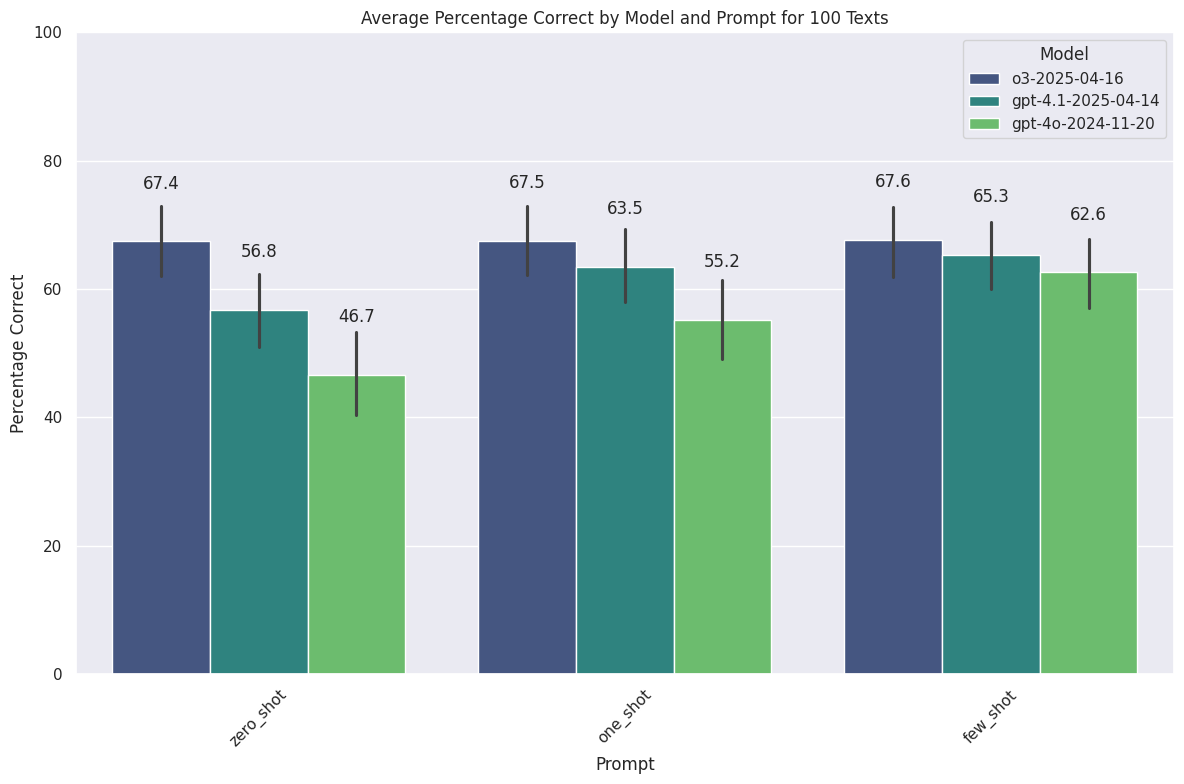

In [61]:
sns.set_theme()

# Create the grouped bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=scoring_results, x="prompt", y="percentage_correct", hue="model", palette="viridis")

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=35)

# Add labels and title
plt.title("Average Percentage Correct by Model and Prompt for 100 Texts")
plt.xlabel("Prompt")
plt.ylabel("Percentage Correct")
plt.ylim(0, 100)
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

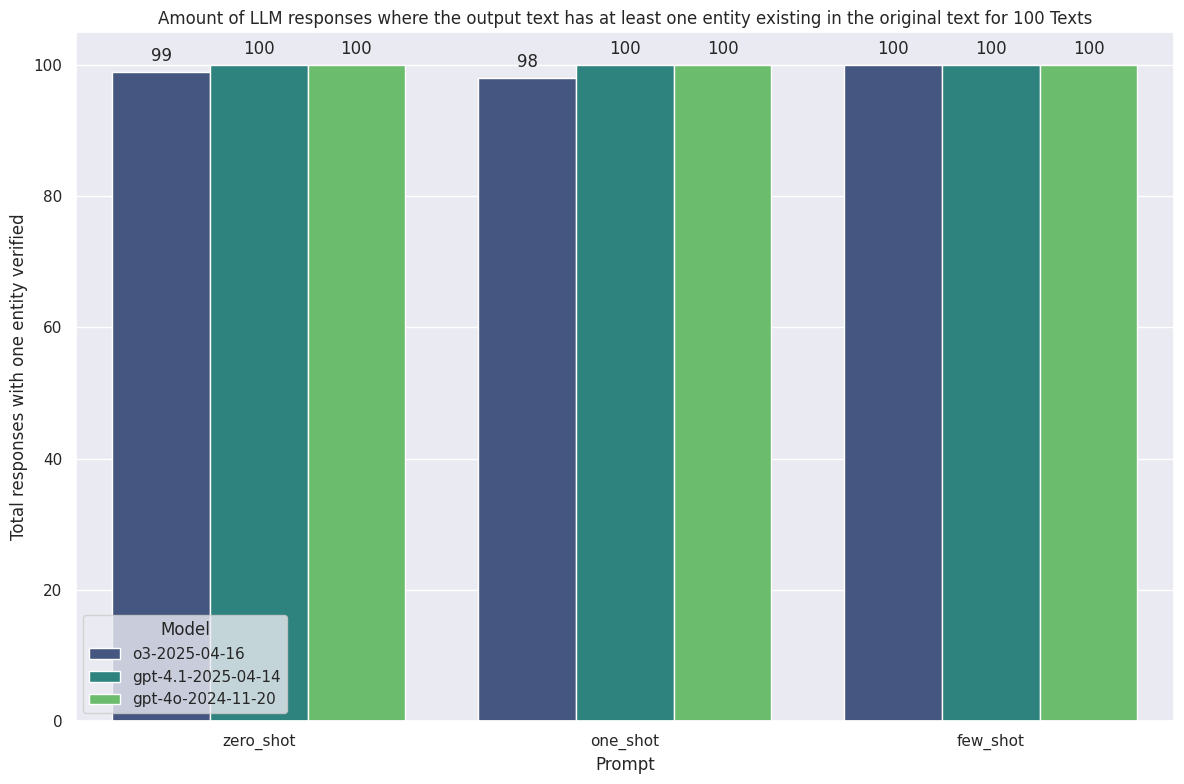

In [62]:
sns.set_theme()

# Create the grouped bar plot
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=qc_results[qc_results['one_entity_verified'] == True], x="prompt", hue="model", palette="viridis")

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=5)

# Add labels and title
plt.title("Amount of LLM responses where the output text has at least one entity existing in the original text for 100 Texts")
plt.xlabel("Prompt")
plt.ylabel("Total responses with one entity verified")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

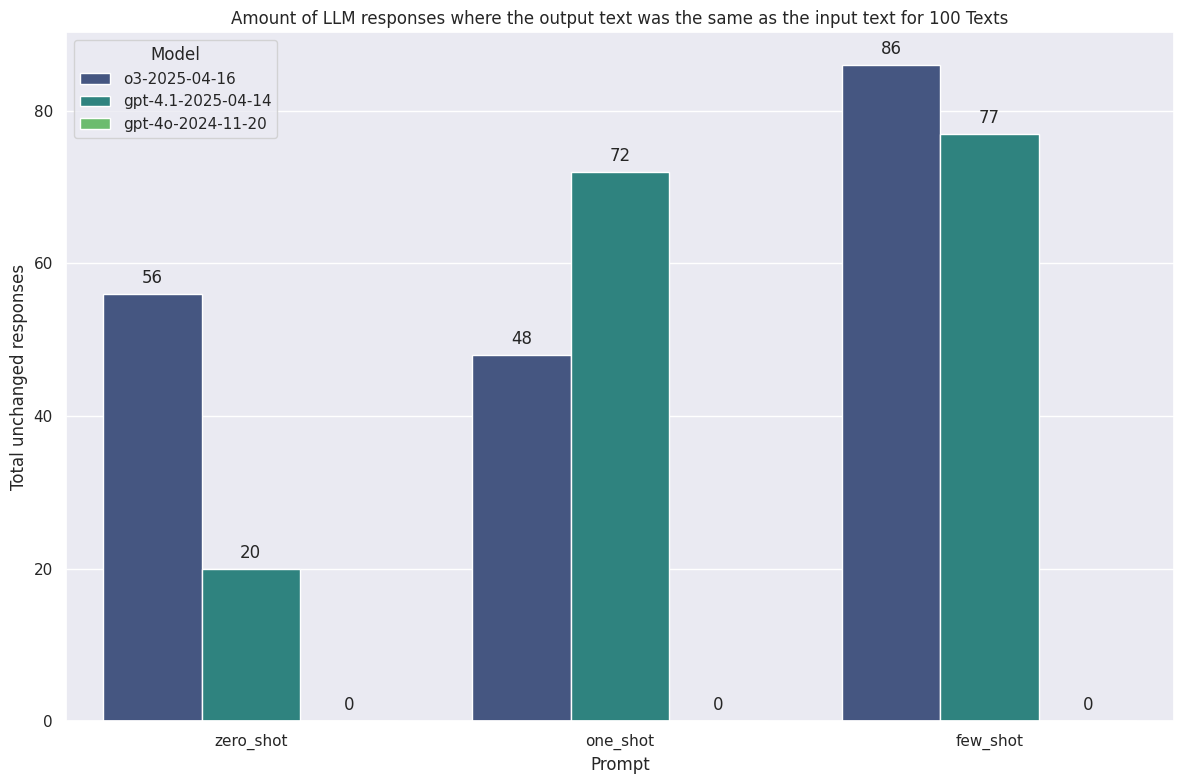

In [63]:
# Create a DataFrame with all combinations of prompts and models
all_combinations = pd.MultiIndex.from_product(
    [qc_results['prompt'].unique(), qc_results['model'].unique()],
    names=['prompt', 'model']
).to_frame(index=False)

# Filter only the True values (text unchanged)
true_counts = qc_results[qc_results['text_unchanged'] == True].groupby(
    ['prompt', 'model']
).size().reset_index(name='count')

# Merge with all combinations to fill in missing pairs with 0
complete_df = pd.merge(all_combinations, true_counts, on=['prompt', 'model'], how='left').fillna(0)
complete_df['count'] = complete_df['count'].astype(int)

# Plot using seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=complete_df, x="prompt", y="count", hue="model", palette="viridis")

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=5)

# Add labels and title
plt.title("Amount of LLM responses where the output text was the same as the input text for 100 Texts")
plt.xlabel("Prompt")
plt.ylabel("Total unchanged responses")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

$$
  \text{Precision} = \frac{\text{nb correct entities found}}{\text{nb entities predicted}}
$$

$$
  \text{Recall} = \frac{\text{nb correct entities found}}{\text{nb ground-truth entities}}
$$


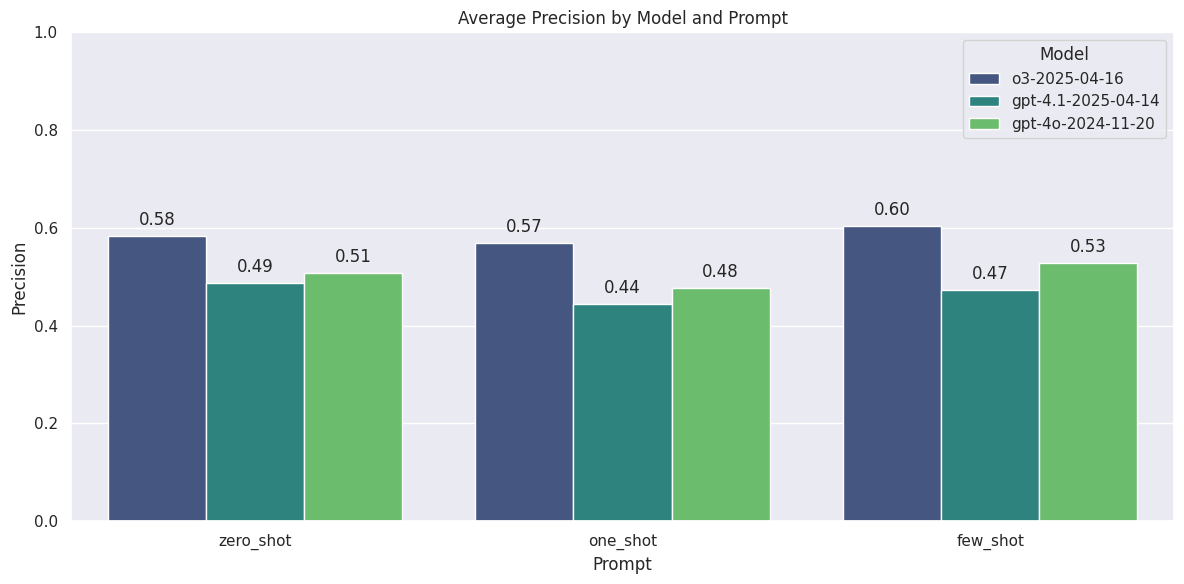

In [77]:
model_order = [
    "o3-2025-04-16",
    "gpt-4.1-2025-04-14",
    "gpt-4o-2024-11-20",
]

prompt_order = [
    "zero_shot",
    "one_shot",
    "few_shot",
    ]

# Step 1–2: Group and sum
agg = scoring_results.groupby(['model', 'prompt'])[['total_correct', 'total_fp']].sum().reset_index()

# Step 3: Compute precision
agg['precision'] = agg['total_correct'] / (agg['total_correct'] + agg['total_fp'])

# Set the category order
agg['model'] = pd.Categorical(agg['model'], categories=model_order, ordered=True)
agg['prompt'] = pd.Categorical(agg['prompt'], categories=prompt_order, ordered=True)

# Step 4: Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=agg, x='prompt', y='precision', hue='model', palette='viridis')

# Optional: add labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=5)

plt.title("Average Precision by Model and Prompt")
plt.xlabel("Prompt")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


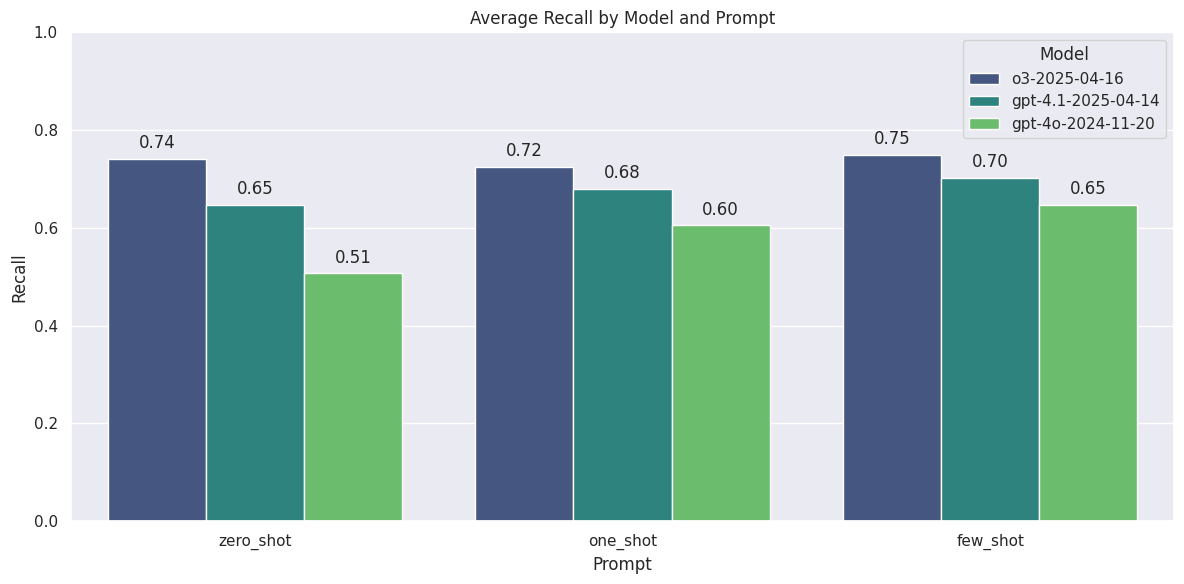

In [76]:
model_order = [
    "o3-2025-04-16",
    "gpt-4.1-2025-04-14",
    "gpt-4o-2024-11-20",
]

prompt_order = [
    "zero_shot",
    "one_shot",
    "few_shot",
    ]

# Step 1–2: Group and sum
agg = scoring_results.groupby(['model', 'prompt'])[['total_correct', 'total']].sum().reset_index()

# Step 3: Compute recall
agg['recall'] = agg['total_correct'] / agg['total']

# Set the category order
agg['model'] = pd.Categorical(agg['model'], categories=model_order, ordered=True)
agg['prompt'] = pd.Categorical(agg['prompt'], categories=prompt_order, ordered=True)

# Step 4: Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=agg, x='prompt', y='recall', hue='model', palette='viridis')

# Optional: add labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=5)

plt.title("Average Recall by Model and Prompt")
plt.xlabel("Prompt")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()